# Test a Custom Dataset Trained with the MNIST Dataset.

**Author** Raphael Perea

The purpose of this tutorial is intended to fill in the gaps for newer users to Pytorch and Python for testing custom datasets. This tutorial will follow the Pytorch Quickstart tutorial (https://pytorch.org/tutorials/beginner/colab) for loading the data from Pytorch's database which we will inspect the format of to match our custom data to for compatibility with Pytorch. A lot the compatibility requirements for datasets are not one size fits all or intuitive to newer users. To accommodate this, a lot of these steps are gathered into one place and further broken down with more visual examples to reinforce why something wont work if the step was skipped.

## Training Data

To load the training data we adapt code from Pytorch's Datasets & DataLoaders tutorial to load the MNIST handwriting dataset instead of FashionMNIST.
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# Load the MNIST Dataset as training data
training_data = datasets.MNIST(
    root="data/training", # Specifies the subdirectory of this files directory.
    train=True,
    download=True,
    transform=ToTensor()
)

# Visualizing Training Dataset
label_map = [0,1,2,3,4,5,6,7,8,9]

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

From the image above we know the dataset is a tensor containing images and labels.

In [ ]:
print(f'training_data: \n{training_data}\n')

# Find shape of array
# training_data.shape # returns an error


Printing the dataset returned a summary of the data instead of printing its values and the shape function errored out. We can still try to find the values by printing the first index "training_data[0]". 

In [ ]:
# inspect the 1st row of data
print(f'training_data[0]: \n{training_data[0]}')

From this first index [0], the pixel values assigned to the image are normalized to 1. We can also tell the image is 1-channel because each pixel is represented by an individual value instead of an [R,G,B] array. At the very end of tensor is the label indicating that the digit is a "5". we will have to match this format when we input our test data.

Next the last index [-1] is inspected as a sanity check for consistancy. Its structure is the same as the first so we can move on.

In [ ]:
# Inspect the last row of data
print(f'training_data[-1]: \n{training_data[-1]}')

The code "img, label = training_data[sample_idx]" from the for loop will separate the image and label. These values only contain the last sample indexed in the loop but this is good enough to find the dimensions of the image.

In [ ]:
# Last Graphed Digit
print(f'label: {label}')         # Show Label
print(f'img.shape: {img.shape}') # Display Image Resolution

## Test Data

### The Dataset (MyImages)

For less challenges we want the test dataset to match the training set as much as possible. MyDataset for this example contains 1000, 28x28, 8-bit greyscale jpgs. All the images for this example were handdrawn by me with a mouse using GIMP as the image software. The images were exported as greyscale JPEGs because this option would produce a single channel image. 500 of the images are 0's labeled as 0's, 493 are 1's labeled as 1's and 7 are blank labeled as 1's. To save time testing compatibility only the 0's and 1's were initially included. The blanks were an accident but I left them in the tutorial because they didn't break the Neural Net and its good practice for encountering bad data.

### Making an index file (MyLabels.csv)

The index file will be necessary to pull the images into Pytorch and assign labels to them. The .csv file was chosen because the Pandas library specifically has a command for reading them. Excluding the #'s, Below is an example of how I formatted the .csv file. CSV stands for comma-separated values where we have each row formatted:

image_file_name,label

Pytorch by default assumes that the first row contains labels. You will want something there so your first index doesn't get skipped. I used "x,y" in this example.

<br>
x,y<br>
0_000.jpg,0<br>
0_001.jpg,0<br>
0_002.jpg,0<br>
0_003.jpg,0<br>
...,...<br>
1_999.jpg,1<br>


### Load and view MyLabels.csv

In [ ]:
import pandas as pd

# File Location
csv_file='MyLabels.csv'

# Load Data
csv_data=pd.read_csv(csv_file)
# See how pandas extracts data from the .csv
print(f'csv_data: \n{csv_data}')


### Preparing the Image Data

In [ ]:
import os
from torchvision.io import read_image

# Image Directory
img_dir='MyImages'

# Appends Image_File_Name to the file path
image0_000=os.path.join(img_dir, csv_data.iloc[0,0])
print(f'\nimage0_000: \n{image0_000}') # Check that they are appended correctly

image0_000 = read_image(image0_000)
print(f'\nimage0_000: \n{image0_000}')

8-bit greyscale .jpg explains the 256 pixel values. The NMIST is normalized to 1 and we need the test data to match that format. If they don't match the MNIST format the training won't have any relevance. We can normalize the test image by dividing all the pixels by the largest value "255".

In [ ]:
# Resets the sample image
image0_000=os.path.join(img_dir, csv_data.iloc[0,0])
image0_000 = read_image(image0_000)

image0_000 = image0_000/255 #  Normalizes the image
print(f'\nimage0_000: \n{image0_000}')

In [ ]:
# Visualizing Training Dataset
img, label = training_data[0]
plt.subplot(121)
plt.title("MNIST Dataset")
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.subplot(122)
plt.title("Custom Dataset")
plt.axis("off")
plt.imshow(image0_000.squeeze(), cmap="gray")

The values are normalized but still inverted. Since the values are normalized we can subtract the image from 1 to invert them.

In [ ]:
image0_000 = 1-image0_000 # Inverts the image

plt.subplot(121)
plt.title("MNIST Dataset")
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.subplot(122)
plt.title("Custom Dataset")
plt.axis("off")
plt.imshow(image0_000.squeeze(), cmap="gray")

### Define an Index Class

We need associate the images to their label so they can be indexed together and match the dataset format ([image, label]) from the Pytorch's built in MNIST dataset. We need a custom class to index because pythons default indexing doesn't work well with combining data imported from text with images. Within this class we can also apply normalization and inversion to the images to match Pytorch's MNIST dataset.

In [33]:
class MyList:
    def __init__(self):
       self.img_dir = img_dir # Image Directory
       self.data = csv_data   # .csv Label Reference

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(img_dir, self.data.iloc[index,0])
        image = read_image(img_path)
        image = 1 - image/255 # Normalize and invert to match MNIST Dataset
        y_label = torch.tensor(int(self.data.iloc[index, 1]))
        return image, y_label

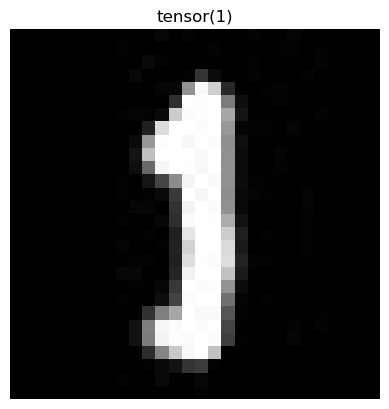

In [40]:
# Load the custom class MYList
test_data = MyList()

# Plot Test Image
image, y_label = test_data[907] # corrupt images: 900-906
plt.title(y_label)
plt.axis("off")
plt.imshow(image.squeeze(), cmap="gray")

# Visualizing Test Dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title( 'index'+str(sample_idx)+': '+str(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Compatibility Test

From here on the custom data will be used in the last part of the beginner's Quickstart Tutorial from Pytorch. https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

Wrap Data for Pytorch

In [35]:
from torch.utils.data import DataLoader

batch_size = 32

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([32, 1, 28, 28])
Shape of y: torch.Size([32]) torch.int64


Load Functions from Quickstart Tutorial

In [36]:
from torch import nn

device = "cpu"

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

# Optimizing the Model Parameters
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Training Code
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Test Code
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

This will run the test. To save time only run 1 epoch.

In [37]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.305869  [   32/60000]
loss: 2.304502  [ 3232/60000]
loss: 2.291805  [ 6432/60000]
loss: 2.292652  [ 9632/60000]
loss: 2.297145  [12832/60000]
loss: 2.289202  [16032/60000]
loss: 2.260747  [19232/60000]
loss: 2.272936  [22432/60000]
loss: 2.262072  [25632/60000]
loss: 2.247424  [28832/60000]
loss: 2.250061  [32032/60000]
loss: 2.263830  [35232/60000]
loss: 2.234978  [38432/60000]
loss: 2.235878  [41632/60000]
loss: 2.264117  [44832/60000]
loss: 2.199687  [48032/60000]
loss: 2.198220  [51232/60000]
loss: 2.213819  [54432/60000]
loss: 2.185065  [57632/60000]
Test Error: 
 Accuracy: 59.2%, Avg loss: 2.160858 

Done!
